In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

In [3]:
df = pd.read_csv('df_english_2.csv')

In [4]:
df.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,Clean_texts,is_english
0,0,86ff1ea1-0b63-43ce-addc-eb43f6193b3b,Yaseen Yaseen,https://play-lh.googleusercontent.com/a/ALm5wu...,Yaeen Yaeen gg,5,0,NaN,2022-10-04 20:32:28,NaN,NaN,been been go,True
1,1,3577f7a1-3394-4e77-813d-095a82cf8bcf,Kemar Richardson,https://play-lh.googleusercontent.com/a-/ACNPE...,Great,5,0,26.3.4,2022-10-04 20:32:10,NaN,NaN,great,True
2,2,7c8c56d9-d8ad-47d4-b24b-5289aa4529ff,Tracy Dunn,https://play-lh.googleusercontent.com/a/ALm5wu...,good,5,0,26.4.3,2022-10-04 20:31:21,NaN,NaN,good,True
3,3,80db804f-cccd-4b09-b690-abc12cbf0612,SG. Mugo. (Mugoz:),https://play-lh.googleusercontent.com/a-/ACNPE...,Good app,5,0,26.3.4,2022-10-04 20:30:22,NaN,NaN,good app,True
4,4,4ed35e90-0f45-4865-81c4-b3a6f2ea49f7,Mwansa Judy,https://play-lh.googleusercontent.com/a-/ACNPE...,Most amazing app,5,0,26.3.4,2022-10-04 20:29:25,NaN,NaN,amazing app,True


In [5]:
df = df[df['Clean_texts'].notna()]

In [6]:
df = df.drop(columns =['Unnamed: 0', 'reviewId'])

In [7]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [13]:
def finalpreprocess(string):
    return lemmatizer(stopword(string))
df['final_text'] = df['Clean_texts'].apply(lambda x: finalpreprocess(x))

In [8]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df['clean_text_tok']=[nltk.word_tokenize(i) for i in df['final_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [9]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"

X_train, X_val, y_train, y_val = train_test_split(df["clean_text"],df["label"],test_size=0.2,shuffle=True)

X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)

#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [30]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict, normalize="true"))
 

              precision    recall  f1-score   support

    NEGATIVE       0.81      0.69      0.74      1975
     NEUTRAL       0.91      0.95      0.93      4721
    POSITIVE       0.96      0.96      0.96     12704

    accuracy                           0.93     19400
   macro avg       0.89      0.87      0.88     19400
weighted avg       0.93      0.93      0.93     19400

Confusion Matrix: [[0.68506329 0.12151899 0.19341772]
 [0.01906376 0.94979877 0.03113747]
 [0.01826196 0.01676637 0.96497166]]


<AxesSubplot:>

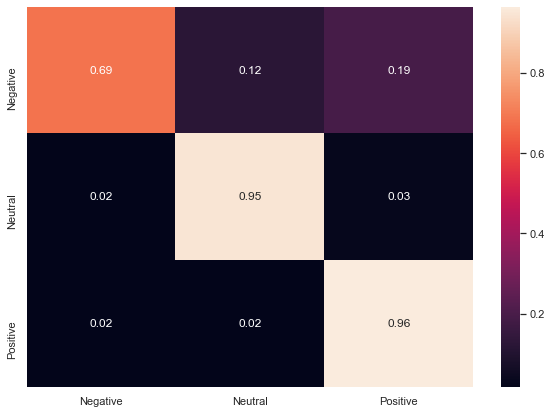

In [33]:
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_val,y_predict)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sb.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])